In [1]:
"""
Getting Started with Quantum Drug Discovery using PennyLane
===========================================================

This notebook demonstrates how to use the quantum drug discovery framework
to train and generate molecular compounds using quantum-enhanced models.

Run each cell sequentially to understand the workflow.
"""

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.error')

# Quantum Drug Discovery with PennyLane

This example demonstrates:
1. Loading and processing molecular data
2. Training a quantum circuit born machine (QCBM)
3. Training a hybrid quantum-classical model
4. Generating and evaluating new molecules
5. Applying molecular filters for drug-likeness

In [2]:
import sys
import os
from pathlib import Path
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path (robust for notebooks where __file__ is undefined)
try:
    here = Path(__file__).resolve().parent
except NameError:
    here = Path(os.getcwd()).resolve()

# If running from notebooks/ set project_root to parent, else use current dir
project_root = here.parent if here.name == 'notebooks' else here

# Add both project root and the src directory to sys.path
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
if str(project_root / 'src') not in sys.path:
    sys.path.insert(0, str(project_root / 'src'))

print(f"Project root: {project_root}")
print(f"Current directory: {os.getcwd()}")

# Try to import the package whether installed (quantum_drug_discovery) or via source tree (src/..)
try:
    from quantum_drug_discovery.models.quantum import PennyLaneQCBM
    from quantum_drug_discovery.models.classical import HybridQuantumLSTMGenerator
    from quantum_drug_discovery.utils.molecular import (
        SmilesProcessor, SelfiesProcessor, CompositeFilter
    )
    from quantum_drug_discovery.training.trainer import MolecularGenerationTrainer
except ImportError:
    from src.quantum_drug_discovery.models.quantum import PennyLaneQCBM
    from src.quantum_drug_discovery.models.classical import HybridQuantumLSTMGenerator
    from src.quantum_drug_discovery.utils.molecular import (
        SmilesProcessor, SelfiesProcessor, CompositeFilter
    )
    from src.quantum_drug_discovery.training.trainer import MolecularGenerationTrainer

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("✅ Imports successful!")
print(f"PyTorch version: {torch.__version__}")

# Resolve best available device (prefer MPS on Apple Silicon, then CUDA, else CPU)
use_mps = hasattr(torch.backends, 'mps') and torch.backends.mps.is_available()
use_cuda = torch.cuda.is_available()
_device_str = 'mps' if use_mps else ('cuda' if use_cuda else 'cpu')
print(f"Device detected: {_device_str.upper()}")

# Check optional dependencies
try:
    import syba
    print("✅ SYBA available for synthetic accessibility scoring")
except ImportError:
    print("⚠️  SYBA not available - synthetic accessibility scoring will be disabled")

Project root: /Users/shawngibford/dev/soma-pennylane
Current directory: /Users/shawngibford/dev/soma-pennylane/notebooks
✅ Imports successful!
PyTorch version: 2.8.0
Device detected: MPS
⚠️  SYBA not available - synthetic accessibility scoring will be disabled


In [3]:
"""
For this example, we'll create a small dataset of drug-like molecules.
In practice, you would load real molecular datasets.
"""

# Sample SMILES strings representing drug-like molecules
sample_molecules = [
    "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O",  # Ibuprofen
    "CC1=CC=C(C=C1)C(=O)C2=CC=CC=C2",  # Deoxybenzoin
    "COC1=CC=CC=C1C2=CC=CC=C2",        # Anisole derivative
    "CC(C)(C)NC(=O)C1=CC=CC=C1",       # Benzamide derivative
    "CCC1=CC=CC=C1N(C)C(=O)CC",        # N-methylbenzamide
    "CC1=CC=C(C=C1)S(=O)(=O)N",        # Sulfonamide
    "COC1=CC=C(C=C1)C=O",              # Vanillin
    "CC(C)C1=CC=CC=C1O",               # Thymol
    "CC1=CC=C(C=C1)C(=O)O",            # p-Toluic acid
    "CCC1=CC=CC=C1C(=O)O",             # Phenylpropionic acid
    "CC1=CC=CC=C1N",                   # o-Toluidine
    "COC1=CC=CC=C1",                   # Anisole
    "CC(C)C1=CC=CC=C1",                # Cumene
    "CC1=CC=C(C=C1)O",                 # p-Cresol
    "CCC1=CC=CC=C1",                   # Propylbenzene
    "CC(C)(C)C1=CC=CC=C1",             # tert-Butylbenzene
    "CC1=CC=CC=C1C",                   # Xylene
    "COC(=O)C1=CC=CC=C1",              # Methyl benzoate
    "CC(=O)C1=CC=CC=C1",               # Acetophenone
    "CC1=CC=CC=C1C=O",                 # o-Tolualdehyde
]

print(f"Created dataset with {len(sample_molecules)} molecules")

# Save sample data
os.makedirs("data/sample", exist_ok=True)
df = pd.DataFrame({"smiles": sample_molecules})
df.to_csv("data/sample/molecules.csv", index=False)
print("💾 Saved sample data to data/sample/molecules.csv")

Created dataset with 20 molecules
💾 Saved sample data to data/sample/molecules.csv


In [4]:
"""
The molecular processor handles encoding/decoding of molecular representations.
We'll use SMILES format for this example.
"""

processor = SmilesProcessor()
processor.smiles_list = sample_molecules
processor._build_vocabulary()

print(f"Vocabulary size: {processor.vocab_size}")
print(f"Max length: {processor.max_length}")
print(f"Sample vocabulary: {processor.vocabulary[:10]}")

# Test encoding/decoding
sample_smiles = sample_molecules[0]
encoded = processor.encode_smiles(sample_smiles)
decoded = processor.decode_sequence(encoded)

print(f"\nEncoding test:")
print(f"Original: {sample_smiles}")
print(f"Encoded:  {encoded[:10]}...")
print(f"Decoded:  {decoded}")
print(f"Valid:    {processor.validate_smiles(decoded)}")

Vocabulary size: 10
Max length: 30
Sample vocabulary: [' ', '(', ')', '1', '2', '=', 'C', 'N', 'O', 'S']

Encoding test:
Original: CC(C)CC1=CC=C(C=C1)C(C)C(=O)O
Encoded:  [6 6 1 6 2 6 6 3 5 6]...
Decoded:  CC(C)CC1=CC=C(C=C1)C(C)C(=O)O
Valid:    True


In [5]:
"""
First, let's train a Quantum Circuit Born Machine to learn the distribution
of molecular features.
"""

# Use the previously detected device
device = torch.device(_device_str)
print(f"Using device: {device}")

# Initialize QCBM
qcbm = PennyLaneQCBM(
    n_qubits=8,  # Smaller for demo
    n_layers=3,
    device_name="default.qubit",
    shots=None,  # Exact simulation
)

print(f"Initialized QCBM: {qcbm}")
print(f"Number of parameters: {qcbm.n_params}")

# Initialize trainer for QCBM
qcbm_trainer = MolecularGenerationTrainer(
    model=qcbm,
    molecular_processor=processor,
    device=device,
    save_dir="./checkpoints/qcbm",
)

# Prepare training data
data_loader = qcbm_trainer.prepare_training_data(
    sample_molecules,
    batch_size=8,
    max_length=processor.max_length,
)

print(f"Created data loader with {len(data_loader)} batches")

# Train QCBM (short training for demo)
print("\n🚀 Training QCBM...")
qcbm_history = qcbm_trainer.train_qcbm_only(
    data_loader=data_loader,
    n_epochs=20,  # Short training for demo
    learning_rate=0.1,
    eval_interval=5,
)

Using device: mps
Initialized QCBM: PennyLaneQCBM(n_qubits=8, n_layers=3, device='default.qubit', shots=None)
Number of parameters: 69
Created data loader with 3 batches

🚀 Training QCBM...


/Users/shawngibford/dev/soma-pennylane/src/quantum_drug_discovery/training/trainer.py:109: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  data_tensor = torch.tensor(encoded_data, dtype=torch.long)
Epoch 1/20: 100%|██████████| 3/3 [00:00<00:00, 49.89it/s, Loss=3.4480]


\nEpoch 1, Average Loss: 4.1913
Generated 200 samples, Valid: 180


Epoch 6/20: 100%|██████████| 3/3 [00:00<00:00, 60.00it/s, Loss=0.7615]


\nEpoch 6, Average Loss: 0.7793
Generated 200 samples, Valid: 2


Epoch 11/20: 100%|██████████| 3/3 [00:00<00:00, 60.77it/s, Loss=0.7086]


\nEpoch 11, Average Loss: 0.7090
Generated 200 samples, Valid: 0


Epoch 16/20: 100%|██████████| 3/3 [00:00<00:00, 61.78it/s, Loss=0.6943]


\nEpoch 16, Average Loss: 0.6950
Generated 200 samples, Valid: 1


Epoch 20/20: 100%|██████████| 3/3 [00:00<00:00, 60.29it/s, Loss=0.6945]



🎲 Generating samples from QCBM...
Generated quantum bitstrings:
Sample 1: [1, 1, 1, 1, 1, 1, 1, 1]
Sample 2: [1, 1, 1, 1, 1, 1, 1, 1]
Sample 3: [1, 1, 0, 1, 0, 1, 0, 1]
Sample 4: [1, 1, 1, 1, 1, 1, 1, 1]
Sample 5: [1, 0, 1, 0, 1, 0, 1, 0]


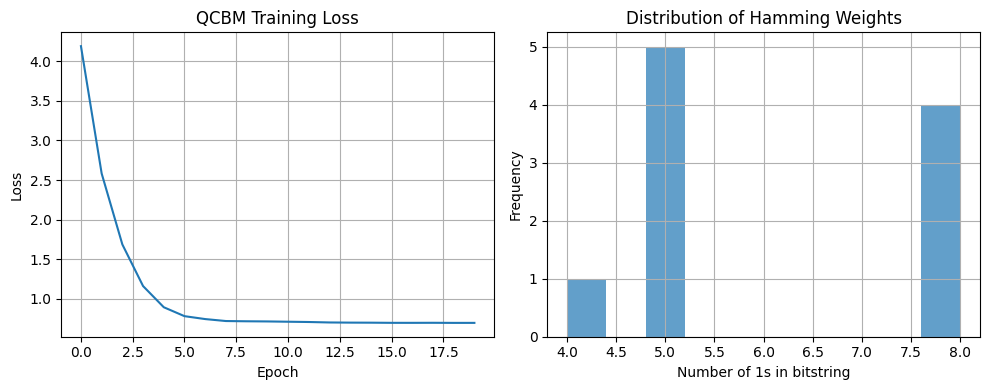

In [6]:
"""
Generate samples from the trained QCBM and visualize the results.
"""

print("\n🎲 Generating samples from QCBM...")
qcbm.eval()
with torch.no_grad():
    quantum_samples = qcbm.generate(10)
    
print("Generated quantum bitstrings:")
for i, sample in enumerate(quantum_samples[:5]):
    print(f"Sample {i+1}: {sample.int().tolist()}")

# Plot training loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(qcbm_history['train_loss'])
plt.title('QCBM Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(quantum_samples.sum(axis=1).cpu().numpy(), bins=10, alpha=0.7)
plt.title('Distribution of Hamming Weights')
plt.xlabel('Number of 1s in bitstring')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.savefig('qcbm_results.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
"""
Now let's train a hybrid quantum-classical model that uses the QCBM
as a prior for an LSTM generator.
"""

print("\n🌟 Setting up hybrid quantum-classical model...")

# Initialize hybrid model
hybrid_model = HybridQuantumLSTMGenerator(
    vocab_size=processor.vocab_size,
    seq_len=processor.max_length,
    n_qubits=8,
    n_layers=3,
    embedding_dim=32,  # Smaller for demo
    hidden_dim=64,
    lstm_layers=2,
    quantum_device="default.qubit",
)

print(f"Initialized hybrid model: {hybrid_model}")
print(f"QCBM config: {hybrid_model.qcbm.config()}")
print(f"LSTM config: {hybrid_model.config()['lstm_config']}")

# Initialize trainer for hybrid model
hybrid_trainer = MolecularGenerationTrainer(
    model=hybrid_model,
    molecular_processor=processor,
    device=device,
    save_dir="./checkpoints/hybrid",
)

# Train hybrid model (short training for demo)
print("\n🚀 Training hybrid model...")
hybrid_history = hybrid_trainer.train_hybrid(
    data_loader=data_loader,
    n_epochs=30,  # Short training for demo
    learning_rate=1e-3,
    quantum_learning_rate=1e-2,
    lambda_quantum=0.1,
    eval_interval=5,
    reference_molecules=sample_molecules,
)


🌟 Setting up hybrid quantum-classical model...
Initialized hybrid model: HybridQuantumLSTMGenerator(
  (qcbm): PennyLaneQCBM(n_qubits=8, n_layers=3, device='default.qubit', shots=None)
  (lstm_generator): QuantumConditionedLSTM(
    (embedding): Embedding(10, 32, padding_idx=0)
    (quantum_projection): Sequential(
      (0): Linear(in_features=8, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
    )
    (lstm): LSTM(96, 64, num_layers=2, batch_first=True, dropout=0.1)
    (output_projection): Linear(in_features=64, out_features=10, bias=True)
    (concat): ConcatenateLayer()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)
QCBM config: {'name': 'PennyLaneQCBM', 'n_qubits': 8, 'n_layers': 3, 'device_name': 'default.qubit', 'shots': None, 'entangling_pattern': 'linear', 'rotation_gates': ['RX', 'RZ'], 'n_params': 69}
LSTM config: {'embedding_dim': 32, 'hidden_dim': 64, 'num_layers': 2, 'projection_dim': 64}

🚀 Training hybrid model...


Epoch 1/30: 100%|██████████| 3/3 [00:00<00:00,  9.41it/s, Loss=2.9658, LSTM=2.1395, Quantum=8.2630] 


\nEvaluating at epoch 1...
Validity: 0.000, Uniqueness: 0.000, Novelty: 0.000, Drug-likeness: 0.000
Checkpoint saved: ./checkpoints/hybrid/checkpoint_epoch_0.pt


Epoch 6/30: 100%|██████████| 3/3 [00:00<00:00, 29.57it/s, Loss=2.0242, LSTM=1.5028, Quantum=5.2133]


\nEvaluating at epoch 6...
Validity: 0.000, Uniqueness: 0.000, Novelty: 0.000, Drug-likeness: 0.000


Epoch 11/30: 100%|██████████| 3/3 [00:00<00:00, 28.44it/s, Loss=1.3021, LSTM=0.9039, Quantum=3.9816]


\nEvaluating at epoch 11...
Validity: 0.000, Uniqueness: 0.000, Novelty: 0.000, Drug-likeness: 0.000
Checkpoint saved: ./checkpoints/hybrid/checkpoint_epoch_10.pt


Epoch 16/30: 100%|██████████| 3/3 [00:00<00:00, 28.40it/s, Loss=1.5416, LSTM=1.2456, Quantum=2.9604]


\nEvaluating at epoch 16...
Validity: 0.000, Uniqueness: 0.000, Novelty: 0.000, Drug-likeness: 0.000


Epoch 21/30: 100%|██████████| 3/3 [00:00<00:00, 27.11it/s, Loss=1.0743, LSTM=0.8510, Quantum=2.2334]


\nEvaluating at epoch 21...
Validity: 0.000, Uniqueness: 0.000, Novelty: 0.000, Drug-likeness: 0.000
Checkpoint saved: ./checkpoints/hybrid/checkpoint_epoch_20.pt


Epoch 26/30: 100%|██████████| 3/3 [00:00<00:00, 29.26it/s, Loss=0.8531, LSTM=0.6744, Quantum=1.7869]


\nEvaluating at epoch 26...
Validity: 0.000, Uniqueness: 0.000, Novelty: 0.000, Drug-likeness: 0.000


Epoch 30/30: 100%|██████████| 3/3 [00:00<00:00, 27.99it/s, Loss=0.8135, LSTM=0.6579, Quantum=1.5568]


In [8]:
"""
Generate new molecules using the trained hybrid model and evaluate their quality.
"""

print("\n🧬 Generating molecules with hybrid model...")

# Generate molecules
hybrid_model.eval()
with torch.no_grad():
    generated_sequences, quantum_priors = hybrid_model.generate(
        n_samples=20,
        temperature=1.0,
        return_quantum_samples=True
    )

# Decode sequences to SMILES
generated_molecules = []
for seq in generated_sequences:
    decoded = processor.decode_sequence(seq.cpu().numpy())
    generated_molecules.append(decoded)

print("Generated molecules:")
for i, mol in enumerate(generated_molecules[:10]):
    valid = processor.validate_smiles(mol)
    print(f"{i+1:2d}. {mol:<30} {'✅' if valid else '❌'}")

# Evaluate generation quality
eval_metrics = hybrid_trainer.evaluate_generation_quality(
    n_samples=50,
    reference_molecules=sample_molecules
)

print(f"\n📊 Generation Quality Metrics:")
print(f"Validity:      {eval_metrics['validity']:.3f}")
print(f"Uniqueness:    {eval_metrics['uniqueness']:.3f}")
print(f"Novelty:       {eval_metrics['novelty']:.3f}")
print(f"Drug-likeness: {eval_metrics['drug_likeness']:.3f}")


🧬 Generating molecules with hybrid model...
Generated molecules:
 1. (C)C)CC1(OCC(CC)C)=CC)=C(1=    ❌
 2. (O(2)=OO1(=)SS)=CCOOCC=C=)=C   ❌
 3. (NC)C)CC(=((O)O=C21            ❌
 4. ()1=NCS1C==()C)=ONN            ❌
 5. ((C=OOOS()=O(21                ❌
 6. (NNCN(O(=)NC=O)O)NN)(=         ❌
 7. (OCCN)CC)OOCO=C=CCC)O=)==      ❌
 8. (SS)(C(CN1=(CN=OS2(=CC=S       ❌
 9. (=SCCSC=NC1))OC)=SO=)2(C       ❌
10. (=C(1=N1)N=CN2SCCO)C==         ❌

📊 Generation Quality Metrics:
Validity:      0.000
Uniqueness:    0.000
Novelty:       0.000
Drug-likeness: 0.000


In [9]:
"""
Apply drug-likeness filters to the generated molecules.
"""

print("\n🔍 Applying molecular filters...")

# Initialize comprehensive filter
molecular_filter = CompositeFilter(
    use_lipinski=True,
    use_pains=True,
    use_structural=True,
    lipinski_violations_max=2
)

# Filter generated molecules
valid_molecules = [mol for mol in generated_molecules if processor.validate_smiles(mol)]
filtered_molecules, results_df = molecular_filter.filter_molecules(valid_molecules)

print(f"Generated: {len(generated_molecules)}")
print(f"Valid:     {len(valid_molecules)}")
print(f"Filtered:  {len(filtered_molecules)}")

# Show filtering statistics
if len(results_df) > 0:
    stats = molecular_filter.get_statistics(results_df)
    print(f"\n📈 Filtering Statistics:")
    print(f"Pass rate: {stats['pass_rate']:.3f}")
    if 'lipinski_pass_rate' in stats:
        print(f"Lipinski pass rate: {stats['lipinski_pass_rate']:.3f}")
    if 'pains_pass_rate' in stats:
        print(f"PAINS pass rate: {stats['pains_pass_rate']:.3f}")

# Show some filtered molecules with properties
print(f"\n🏆 Top filtered molecules:")
for i, mol in enumerate(filtered_molecules[:5]):
    passes, details = molecular_filter.filter_molecule(mol)
    properties = details['lipinski'].get('properties', {})
    mw = properties.get('molecular_weight', 0)
    logp = properties.get('logp', 0)
    print(f"{i+1}. {mol:<25} MW:{mw:.1f} LogP:{logp:.2f}")


🔍 Applying molecular filters...
Generated: 20
Valid:     0
Filtered:  0

🏆 Top filtered molecules:



📈 Creating training visualizations...


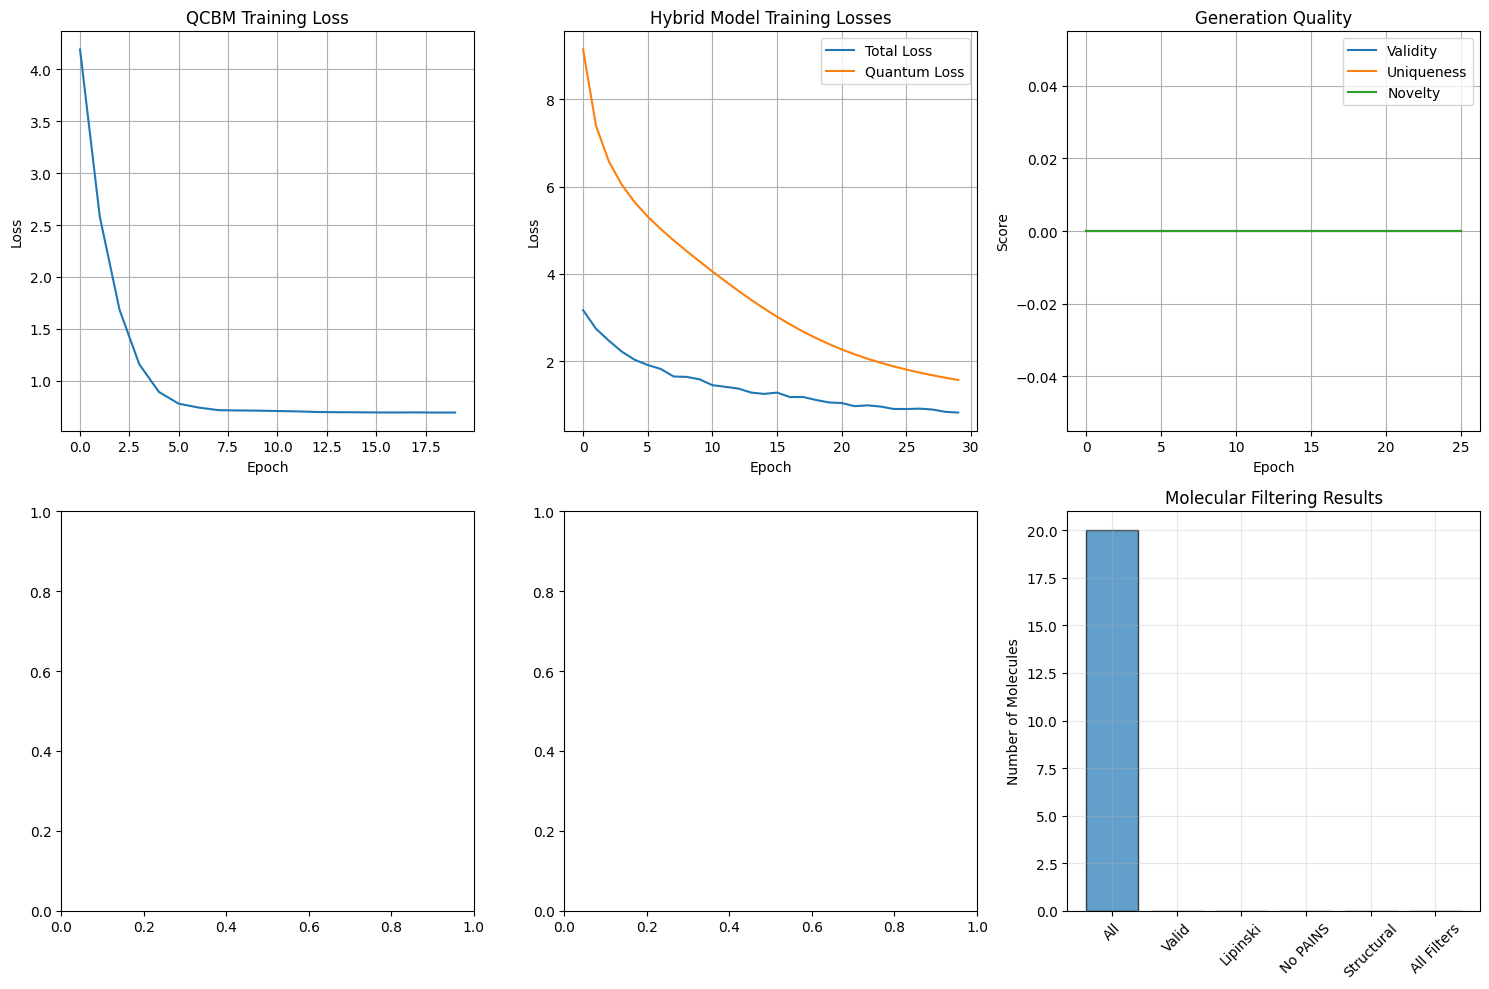

In [10]:
"""
Create comprehensive plots of the training progress.
"""

print("\n📈 Creating training visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# QCBM loss
axes[0, 0].plot(qcbm_history['train_loss'])
axes[0, 0].set_title('QCBM Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True)

# Hybrid model losses
axes[0, 1].plot(hybrid_history['train_loss'], label='Total Loss')
axes[0, 1].plot(hybrid_history['quantum_loss'], label='Quantum Loss')
axes[0, 1].set_title('Hybrid Model Training Losses')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Generation quality metrics
if len(hybrid_history['validity']) > 0:
    epochs = range(0, len(hybrid_history['train_loss']), 
                  len(hybrid_history['train_loss']) // len(hybrid_history['validity']))
    epochs = list(epochs)[:len(hybrid_history['validity'])]
    
    axes[0, 2].plot(epochs, hybrid_history['validity'], label='Validity')
    axes[0, 2].plot(epochs, hybrid_history['uniqueness'], label='Uniqueness')
    axes[0, 2].plot(epochs, hybrid_history['novelty'], label='Novelty')
    axes[0, 2].set_title('Generation Quality')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Score')
    axes[0, 2].legend()
    axes[0, 2].grid(True)

# Molecular property distributions (if we have valid molecules)
if len(valid_molecules) > 0 and len(results_df) > 0:
    # Molecular weights
    mws = [details['lipinski']['properties']['molecular_weight'] 
           for _, details in results_df.iterrows() 
           if details['lipinski'] and details['lipinski']['properties']]
    if mws:
        axes[1, 0].hist(mws, bins=10, alpha=0.7, edgecolor='black')
        axes[1, 0].axvline(500, color='red', linestyle='--', label='Lipinski MW limit')
        axes[1, 0].set_title('Molecular Weight Distribution')
        axes[1, 0].set_xlabel('Molecular Weight (Da)')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

    # LogP values
    logps = [details['lipinski']['properties']['logp'] 
             for _, details in results_df.iterrows() 
             if details['lipinski'] and details['lipinski']['properties']]
    if logps:
        axes[1, 1].hist(logps, bins=10, alpha=0.7, edgecolor='black')
        axes[1, 1].axvline(5, color='red', linestyle='--', label='Lipinski LogP limit')
        axes[1, 1].set_title('LogP Distribution')
        axes[1, 1].set_xlabel('LogP')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

# Filter pass rates
filter_data = {
    'All': len(generated_molecules),
    'Valid': len(valid_molecules),
    'Lipinski': len([m for m in valid_molecules if molecular_filter.lipinski_filter.passes_lipinski(m)]),
    'No PAINS': len([m for m in valid_molecules if not molecular_filter.pains_filter.has_pains_substructure(m)]),
    'Structural': len([m for m in valid_molecules if molecular_filter.structural_filter.passes_structural_filters(m)]),
    'All Filters': len(filtered_molecules)
}

axes[1, 2].bar(filter_data.keys(), filter_data.values(), alpha=0.7, edgecolor='black')
axes[1, 2].set_title('Molecular Filtering Results')
axes[1, 2].set_ylabel('Number of Molecules')
axes[1, 2].tick_params(axis='x', rotation=45)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_results.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
"""
Compare the properties of generated molecules with the original dataset.
"""

print("\n🔄 Comparing generated vs. original molecules...")

# Compute properties for original molecules
original_properties = []
for mol in sample_molecules:
    passes, details = molecular_filter.filter_molecule(mol)
    if details['lipinski'] and details['lipinski']['properties']:
        original_properties.append(details['lipinski']['properties'])

# Compute properties for generated molecules
generated_properties = []
for mol in valid_molecules:
    passes, details = molecular_filter.filter_molecule(mol)
    if details['lipinski'] and details['lipinski']['properties']:
        generated_properties.append(details['lipinski']['properties'])

if original_properties and generated_properties:
    # Create comparison plots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Molecular weight comparison
    orig_mw = [p['molecular_weight'] for p in original_properties]
    gen_mw = [p['molecular_weight'] for p in generated_properties]
    
    axes[0].hist(orig_mw, bins=10, alpha=0.7, label='Original', edgecolor='black')
    axes[0].hist(gen_mw, bins=10, alpha=0.7, label='Generated', edgecolor='black')
    axes[0].set_title('Molecular Weight Comparison')
    axes[0].set_xlabel('Molecular Weight (Da)')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    axes[0].grid(True)
    
    # LogP comparison
    orig_logp = [p['logp'] for p in original_properties]
    gen_logp = [p['logp'] for p in generated_properties]
    
    axes[1].hist(orig_logp, bins=10, alpha=0.7, label='Original', edgecolor='black')
    axes[1].hist(gen_logp, bins=10, alpha=0.7, label='Generated', edgecolor='black')
    axes[1].set_title('LogP Comparison')
    axes[1].set_xlabel('LogP')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig('property_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print(f"Original molecules - MW: {np.mean(orig_mw):.1f}±{np.std(orig_mw):.1f}, LogP: {np.mean(orig_logp):.2f}±{np.std(orig_logp):.2f}")
    print(f"Generated molecules - MW: {np.mean(gen_mw):.1f}±{np.std(gen_mw):.1f}, LogP: {np.mean(gen_logp):.2f}±{np.std(gen_logp):.2f}")


🔄 Comparing generated vs. original molecules...


In [12]:
"""
Summarize the results and provide guidance for next steps.
"""

print("\n" + "="*60)
print("🎉 QUANTUM DRUG DISCOVERY DEMO COMPLETE!")
print("="*60)

print(f"\n📊 Final Results Summary:")
print(f"• QCBM trained with {qcbm.n_params} parameters")
print(f"• Hybrid model trained on {len(sample_molecules)} molecules")
print(f"• Generated {len(generated_molecules)} molecules")

# Guard denominators to avoid ZeroDivisionError when there are no generated/valid molecules
_total = len(generated_molecules)
_valid = len(valid_molecules)
_drug_like = len(filtered_molecules)

_valid_pct = (_valid / _total * 100) if _total else 0.0
print(f"• {_valid} valid molecules ({_valid_pct:.1f}%)")

if _valid:
    _drug_like_pct = _drug_like / _valid * 100
    print(f"• {_drug_like} drug-like molecules ({_drug_like_pct:.1f}% of valid)")
else:
    print("• 0 drug-like molecules (n/a of valid)")

print(f"\n🎯 Key Metrics:")
print(f"• Validity:      {eval_metrics['validity']:.3f}")
print(f"• Uniqueness:    {eval_metrics['uniqueness']:.3f}")
print(f"• Novelty:       {eval_metrics['novelty']:.3f}")
print(f"• Drug-likeness: {eval_metrics['drug_likeness']:.3f}")

print(f"\n🔄 Next Steps:")
print("1. Train on larger molecular datasets (ChEMBL, ZINC, etc.)")
print("2. Experiment with different quantum circuit architectures")
print("3. Optimize hyperparameters using Optuna or similar")
print("4. Implement more sophisticated molecular property predictors")
print("5. Add reinforcement learning for targeted molecular optimization")
print("6. Compare with classical baselines (VAE, GAN, etc.)")

print(f"\n💾 Files saved:")
print("• qcbm_results.png - QCBM training visualization")
print("• training_results.png - Comprehensive training results")
print("• property_comparison.png - Original vs generated molecule comparison")
print("• Checkpoints saved in ./checkpoints/")

print("\n✨ Thank you for trying Quantum Drug Discovery with PennyLane!")


🎉 QUANTUM DRUG DISCOVERY DEMO COMPLETE!

📊 Final Results Summary:
• QCBM trained with 69 parameters
• Hybrid model trained on 20 molecules
• Generated 20 molecules
• 0 valid molecules (0.0%)
• 0 drug-like molecules (n/a of valid)

🎯 Key Metrics:
• Validity:      0.000
• Uniqueness:    0.000
• Novelty:       0.000
• Drug-likeness: 0.000

🔄 Next Steps:
1. Train on larger molecular datasets (ChEMBL, ZINC, etc.)
2. Experiment with different quantum circuit architectures
3. Optimize hyperparameters using Optuna or similar
4. Implement more sophisticated molecular property predictors
5. Add reinforcement learning for targeted molecular optimization
6. Compare with classical baselines (VAE, GAN, etc.)

💾 Files saved:
• qcbm_results.png - QCBM training visualization
• training_results.png - Comprehensive training results
• property_comparison.png - Original vs generated molecule comparison
• Checkpoints saved in ./checkpoints/

✨ Thank you for trying Quantum Drug Discovery with PennyLane!
